In [2]:
import graph_tool.all as gt
import pandas as pd
import numpy as np
import scipy as sc

In [3]:
#generate network
g = gt.load_graph("/home/gdj/gdj_data/DeviceMov_covid19mx/results/g_2020_02_18.graphml")
g = gt.GraphView(g, vfilt=gt.label_largest_component(g))
g = gt.Graph(g, prune=True)
g

<Graph object, undirected, with 134763 vertices and 1695175 edges, 2 internal vertex properties, 2 internal edge properties, at 0x7fc39291fd30>

In [4]:
%time
#get blockmodel
state = gt.minimize_blockmodel_dl(g)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 31.9 µs


In [5]:
#extract blockmodel membership
unos_datos = state.b.a
df = pd.DataFrame(data=unos_datos, columns = ["comunidades"])
df.head()


,comunidades
0,0
1,1
2,2
3,3
4,4


In [35]:
gt.modularity(g, state.b)

0.40095175859262217

In [6]:
#count blockmodel members
my_tally = df.value_counts(sort=False).rename("N").reset_index()


In [7]:
my_tally

,comunidades,N
0,0,552
1,1,4446
2,2,1930
3,3,17750
4,4,616
...,...,...
700,700,39
701,701,49
702,702,24
703,703,43


In [8]:
#scale down
my_tally["redondeado"] = np.ceil(my_tally["N"] * 0.1)
my_tally


,comunidades,N,redondeado
0,0,552,56.0
1,1,4446,445.0
2,2,1930,193.0
3,3,17750,1775.0
4,4,616,62.0
...,...,...,...
700,700,39,4.0
701,701,49,5.0
702,702,24,3.0
703,703,43,5.0


In [9]:
#make empty array to fill with nodes members of block
my_array = []


In [10]:
#fill array
for i, j in zip(my_tally.comunidades, my_tally.redondeado.astype(int)):  
    my_array.extend([i] * j)


In [11]:
#get the block adjacency matrix
my_adj = gt.adjacency(state.get_bg(), state.get_ers()).T


In [12]:
#escalar esta matriz para que tenga el numero de enlaces escalados
n = len(my_tally.N)
matrix_enlaces_totales = np.zeros((n,n)) # Pre-allocate matrix

for r in range(0,n):
    for s in range(0,n):
        matrix_enlaces_totales[r,s] = (my_tally.N[r] * my_tally.N[s])


In [13]:
#sacar la fraccion de enlaces reales
matrix_fraccion = np.zeros((n,n)) # Pre-allocate matrix

for r in range(0,n):
    for s in range(0,n):
        matrix_fraccion[r,s] = my_adj.toarray()[r,s] / matrix_enlaces_totales[r,s]


In [14]:
#escalar la matriz propiamente
matrix_escalado = np.zeros((n,n)) # Pre-allocate matrix

for r in range(0,n):
    for s in range(0,n):
        matrix_escalado[r,s] = np.ceil(matrix_fraccion[r,s] * (my_tally.redondeado[r] * my_tally.redondeado[r]))

In [20]:
#generar nueva red, escalada
u = gt.generate_sbm(b= my_array, probs = matrix_escalado)
#dejar solo LCC para mejor manejo
u = gt.GraphView(u, vfilt=gt.label_largest_component(u))
u = gt.Graph(u, prune=True)
u

<Graph object, undirected, with 7216 vertices and 86775 edges, at 0x7fc2b2626fa0>

In [21]:
#sacar el nuevo modelo de bloques
state_u  = gt.minimize_blockmodel_dl(u)

In [ ]:
#big nw structure
#state.draw(pos=g.vp["pos"], vertex_shape=state.get_blocks()

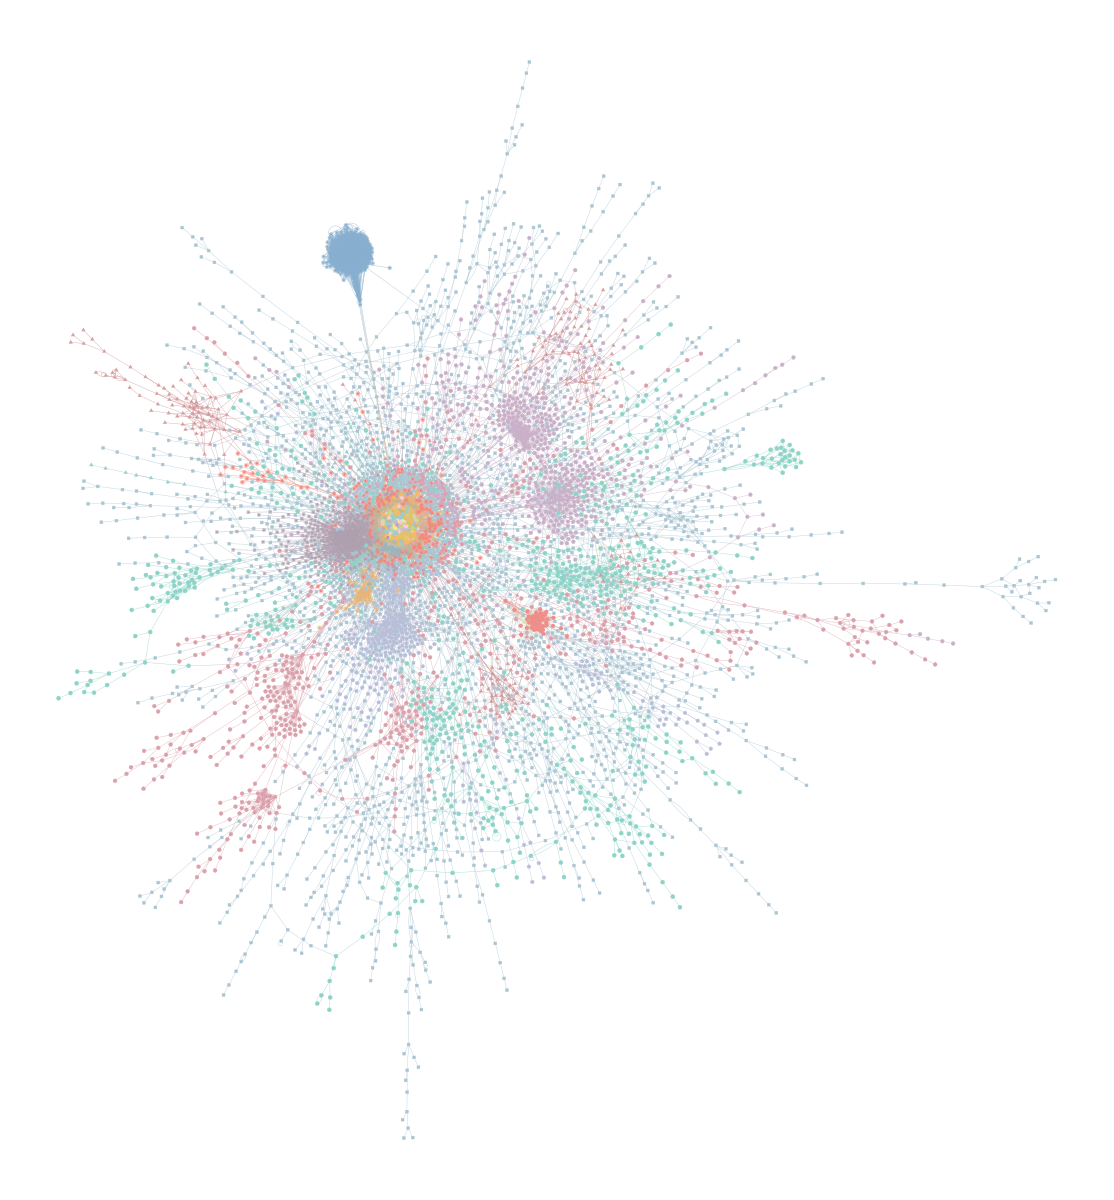

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc2b2626fa0, at 0x7fc2b2611af0>

In [22]:
#small nw structure
state_u.draw(vertex_shape=state_u.get_blocks())

In [23]:
hist_u = gt.vertex_hist(u, "total")
hist_g = gt.vertex_hist(g, "total")

In [26]:
len(hist_g[1])

3726

In [27]:
u_df = pd.DataFrame({"x" : hist_u[1][:567], 
                     "y" : hist_u[0]}
                   )

g_df = pd.DataFrame({"x" : hist_g[1][:3725], 
                     "y" : hist_g[0]}
                   )


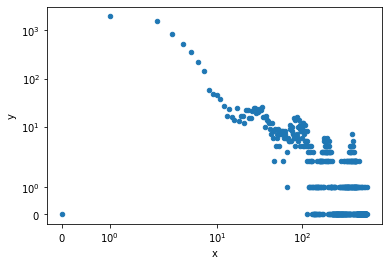

In [28]:
u_df.plot(kind="scatter", x="x", y="y", loglog="sym")

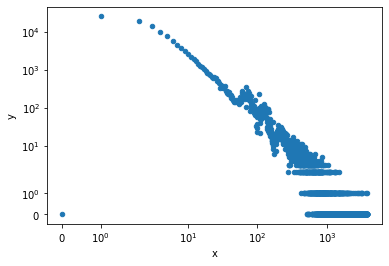

In [29]:
g_df.plot(kind="scatter", x="x", y="y", loglog="sym")

In [36]:
gt.modularity(u, state_u.b)

0.22389581588933655

In [39]:
#extract blockmodel membership
u_modules = state_u.b.a
df_u = pd.DataFrame(data=u_modules, columns = ["comunidades"])
df_u = df_u.value_counts(sort=True).rename("N").reset_index()
df_u.head()


,comunidades,N
0,2,2458
1,0,726
2,4,636
3,5,618
4,10,579


In [30]:
#save network 
u.save("/home/gdj/gdj_data/DeviceMov_covid19mx/results/scaled_10x_g_2020_02_18.graphml")

## Compare modularity between networks

In [41]:
simple_g = gt.load_graph("/home/gdj/gdj_data/DeviceMov_covid19mx/results/scaled_10x_g_2020_02_18_simplified.graphml")

In [42]:
simple_g

<Graph object, undirected, with 7216 vertices and 68060 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fc2a8fc9a60>

In [46]:
simple_g_blockmodel = gt.minimize_blockmodel_dl(simple_g)

## step 1: compare the actual Q value

In [47]:
gt.modularity(g, state.b)

0.40095175859262217

In [48]:
gt.modularity(simple_g, simple_g_blockmodel.b)

0.24965276701366937

## step 2: compare the block size distribution

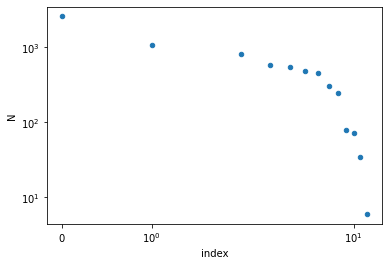

In [55]:
#extract blockmodel membership
simple_g_modules = simple_g_blockmodel.b.a
simple_g_modules = pd.DataFrame(data=simple_g_modules, columns = ["comunidades"])
simple_g_modules = simple_g_modules.value_counts(sort=True).rename("N").reset_index()
#simple_g_modules.head()
simple_g_modules.reset_index().plot(kind="scatter", x="index", y="N", loglog="sym")


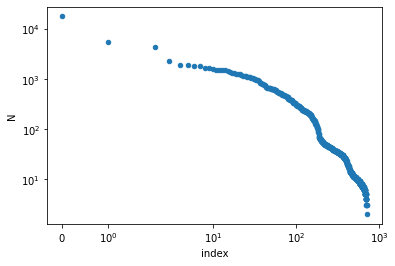

In [58]:
g_modules = df.value_counts(sort=True).rename("N").reset_index()
g_modules.reset_index().plot(kind="scatter", x="index", y="N", loglog="sym")

In [59]:
gt.global_clustering(g)

(0.2846981190566901, 0.008246375538035828)

In [60]:
gt.global_clustering(simple_g)

(0.2679566396725453, 0.0017224015887075416)